In [2]:
% matplotlib inline
from __future__ import unicode_literals
from nltk.stem.snowball import SnowballStemmer
import nltk
import sys
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime

reload(sys)
sys.setdefaultencoding('utf8')
# nltk.download('punkt')
stemmer = SnowballStemmer('english')

In [3]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

# tokenize words in docs
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

df_perf = pd.read_pickle('Projects/descriptions.pkl')

stemmed = []
tokenized = []
for i in df_perf.description.values:
    w_stemmed = tokenize_and_stem(i)
    stemmed.extend(w_stemmed)

    w_tokenized = tokenize_only(i)
    tokenized.extend(w_tokenized)

vf = pd.DataFrame({'words': tokenized}, index = stemmed)

In [4]:
# compute tfidf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=39500, max_df=.7, min_df=.2, stop_words='english',
                             tokenizer=tokenize_and_stem, ngram_range=(1,3))
tfidf_mat = tfidf_vect.fit_transform(df_perf.description.values)
terms = tfidf_vect.get_feature_names()

In [5]:
# k-means
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=0)
km.fit(tfidf_mat)
clusters = km.labels_.tolist()

In [6]:
# create features
df = pd.read_csv('~/Downloads/mdst-getstarted/ums/data/ums_viz.csv', parse_dates=[1,4,12])
df_perf.columns.values[0] = 'perf_name'
df_perf['topic'] = clusters

clust_dict = dict(zip(df_perf['perf_name'], clusters))
df['topic'] = df['perf_name'].map(clust_dict.get)

df['perf_name'] = df['perf_name'].apply(lambda x: x.strip())
df_perf['perf_name'] = df_perf['perf_name'].apply(lambda x: x.strip())

df['per_seat'] = df['tck_amt']/df['num_seats']

df['sprop'] = df['price_type_group'] == 'Student Prices'

df['acct_age'] = df['order_dt'] - df['acct_created']
df['acct_age'] = df['acct_age'].apply(lambda x: x.days)

df['delta_sale'] = df['perf_dt'] - df['order_dt']
df['delta_sale'] = df['delta_sale'].apply(lambda x: x.days)

df_group = df.groupby('perf_name')

# separate data frame for students
df_stud_group = df[df['price_type_group'] == 'Student Prices'].groupby('perf_name')

In [7]:
# mean ticket amount, number of seats, price per seat, proportion of student tickets
df_tmp = df_group['tck_amt', 'num_seats', 'per_seat', 'sprop'].mean().reset_index()
df_tmp = df_tmp.rename(columns={'tck_amt': 'mean_tck_amt', 'num_seats': 'mean_num_seats', 'per_seat': 'mean_per_seat', 'sprop': 'sprop'})
df_perf = pd.merge(df_perf, df_tmp, on='perf_name')
df_perf['sprop'] = pd.to_numeric(df_perf['sprop'], errors='coerce')

# number of total seats, student seats
df_tmp = df_group['num_seats'].count().reset_index().rename(columns={'num_seats': 'count_tck'})
df_perf = pd.merge(df_perf, df_tmp, on='perf_name')
df_tmp = df_stud_group['num_seats'].count().reset_index().rename(columns={'num_seats': 'count_stud_tck'})
df_perf = pd.merge(df_perf, df_tmp, on='perf_name', how='left')

# account age, delta time before sale
df_tmp = df_group['acct_age', 'delta_sale'].mean().reset_index()
df_perf = pd.merge(df_perf, df_tmp, on='perf_name')

df_grp = df_perf.groupby('topic')
df_agg = df_perf.groupby('topic').mean()

df_agg['acct_age'] = df_agg['acct_age'].apply(lambda x: datetime.timedelta(seconds=x))
df_agg['delta_sale'] = df_agg['delta_sale'].apply(lambda x: datetime.timedelta(seconds=x))

print df_agg.head()

In [8]:
from collections import defaultdict

order_centroids = km.cluster_centers_.argsort()[:,::-1]
words_by_topic = defaultdict(list)

for i in range(num_clusters):
    print "\nCluster %d words:" % i,
    for ind in order_centroids[i,:10]:
        word = vf.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')
        words_by_topic[i].append(word)
        print '%s,' % word,
    print
    print "\nCluster %d performances:" % i,
    perfs = sorted(df_grp.get_group(i)['perf_name'])
    for perf in perfs:
        print '\n%s' % perf,
    print

for i in range(num_clusters):
    words_by_topic[i] = list(set(words_by_topic[i]))

In [9]:
# MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

dist = 1 - cosine_similarity(tfidf_mat)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
pos = mds.fit_transform(dist)
xs, ys = pos[:,0], pos[:,1]

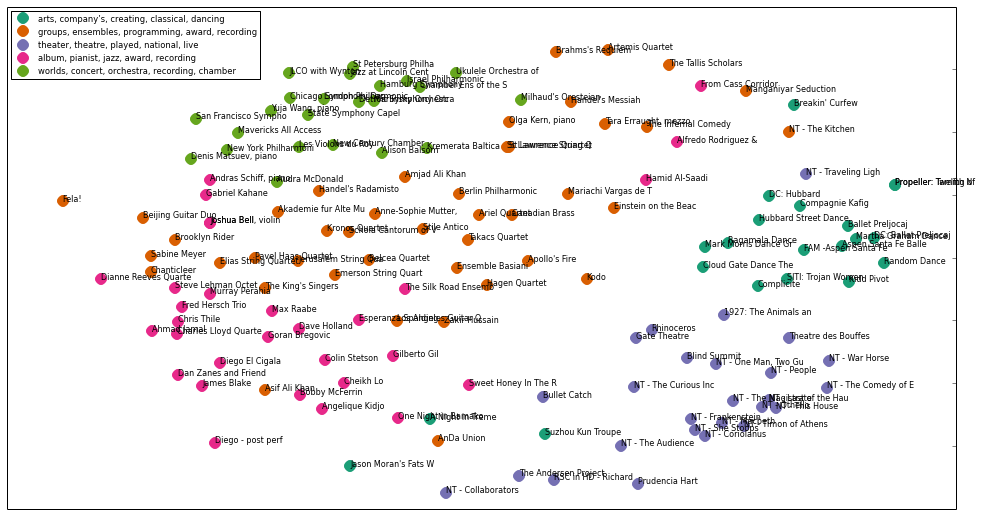

In [10]:
# visualize clusters
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
cluster_names = {0: ', '.join(words_by_topic[0][:5]),
                 1: ', '.join(words_by_topic[1][:5]),
                 2: ', '.join(words_by_topic[2][:5]),
                 3: ', '.join(words_by_topic[3][:5]),
                 4: ', '.join(words_by_topic[4][:5])}
df2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, perf=df_perf['perf_name']))
groups = df2.groupby('label')

fig, ax = plt.subplots(figsize=(17,9))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')

ax.legend(loc='upper left', numpoints=1, fontsize='small')

for i in range(len(df2)):
    ax.text(df2.ix[i]['x'], df2.ix[i]['y'], df2.ix[i]['perf'], size=8)

plt.savefig('Projects/images/cluster_viz.png', dpi=200)
plt.show()

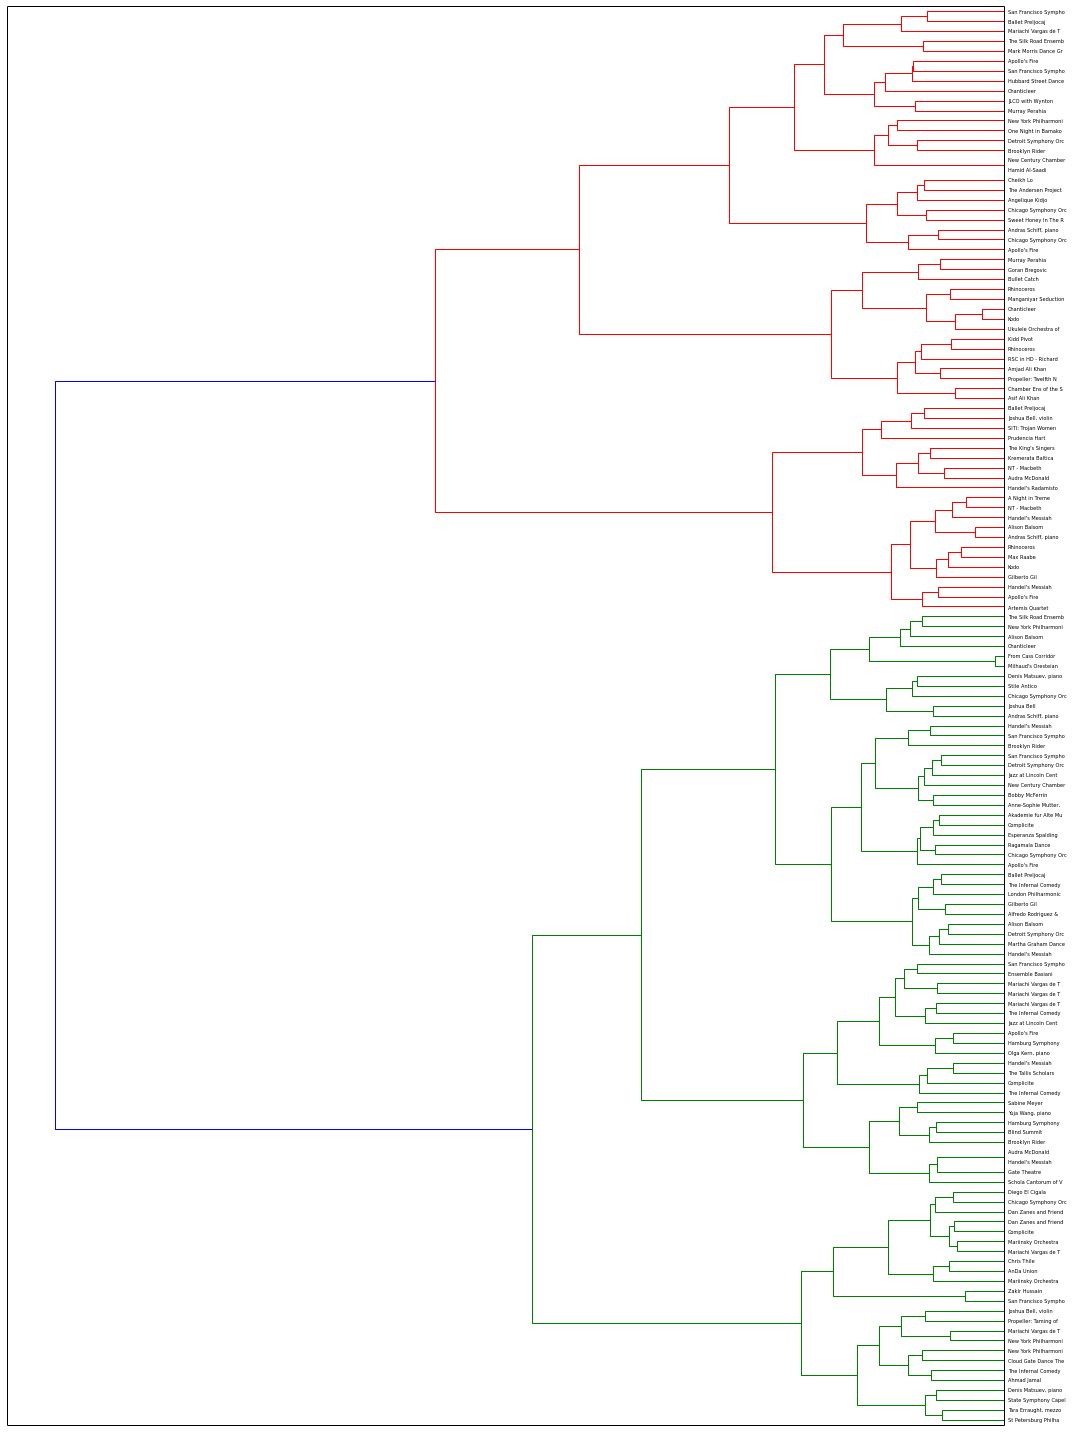

In [11]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_mat = ward(dist)

fig, ax = plt.subplots(figsize=(15,20))
ax = dendrogram(linkage_mat, orientation='left', labels=df['perf_name'].tolist());

plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.tight_layout()
plt.savefig('Projects/images/ward_clusters.png', dpi=200)
plt.show()

In [12]:
def assign_topics(words_by_topic):
    t_list = range(5)
    for k, word_list in words_by_topic.iteritems():
        for word in word_list:
            if word == 'dancing':
                t_list[k] = 'dance'
                break
            elif word == 'ensembles':
                t_list[k] = 'ensemble'
                break
            elif word == 'theater':
                t_list[k] = 'theater'
                break
            elif word == 'orchestra':
                t_list[k] = 'orchestra'
                break
            elif word == 'jazz':
                t_list[k] = 'contemporary'
                break
    return t_list

t_list = assign_topics(words_by_topic)
print t_list

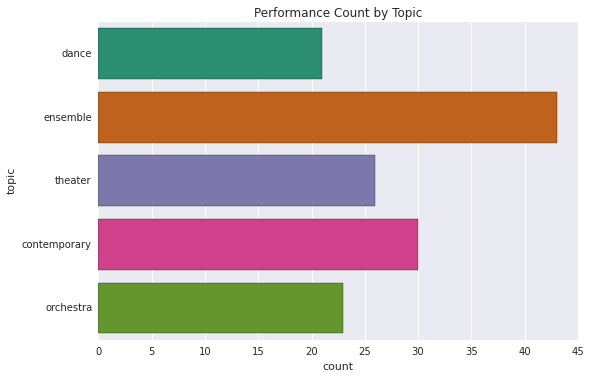

In [13]:
import seaborn as sns
import numpy as np

topic_range = range(5)
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

sns.factorplot(y='topic', data=df_perf, kind='count', palette=cluster_colors, size=5, aspect=1.5, order=topic_range)

plt.title('Performance Count by Topic')
plt.yticks(range(5), t_list)
plt.show()

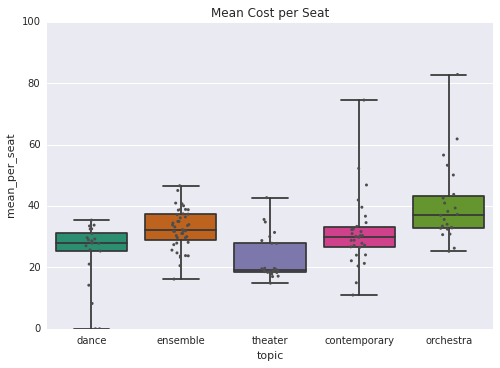

In [14]:
ax = sns.boxplot(x="topic", y="mean_per_seat", data=df_perf, whis=np.inf, palette=cluster_colors, order=topic_range)
sp = sns.stripplot(x="topic", y="mean_per_seat", data=df_perf, jitter=True, size=3, color=".3", linewidth=0, order=topic_range)

plt.title('Mean Cost per Seat')
plt.xticks(range(5), t_list)
sp.set_ylim([0, 100])
plt.savefig('Projects/images/mean_cost.png', dpi=100)
plt.show()

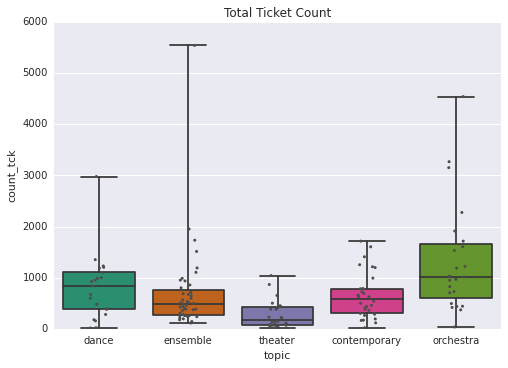

In [15]:
ax = sns.boxplot(x="topic", y="count_tck", data=df_perf, whis=np.inf, palette=cluster_colors, order=topic_range)
sp = sns.stripplot(x="topic", y="count_tck", data=df_perf, jitter=True, size=3, color=".3", linewidth=0, order=topic_range)

plt.title('Total Ticket Count')
plt.xticks(range(5), t_list)
sp.set_ylim([0, 6000])
plt.savefig('Projects/images/tck_count.png', dpi=100)
plt.show()

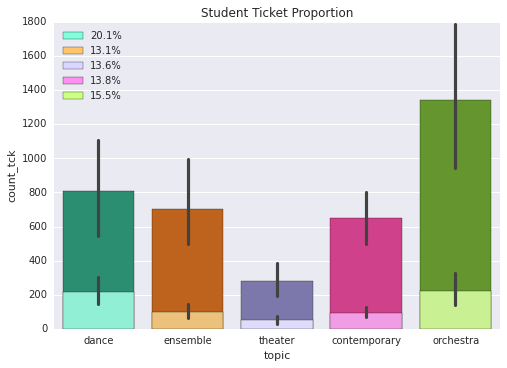

In [16]:
import matplotlib as mpl

light = {0: '#81FFDD',1: '#FFC568',2: '#DBD6FF',3: '#FF8FF0',4: '#CCFF84'}

sns.barplot(x=df_perf['topic'], y=df_perf['count_tck'], palette=cluster_colors)
bottom_plot = sns.barplot(x=df_perf['topic'], y=df_perf['count_stud_tck'], palette=light)

topbar = plt.Rectangle((0,0),1,1,edgecolor='none')
bottombar = plt.Rectangle((0,0),1,1,edgecolor='none')

patches = [plt.Rectangle((0,0),1,1,fc=light.values()[x]) for x in range(5)]
labels = df_agg['sprop'].tolist()
labels = [str(float('%.3f' % l) * 100) + '%' for l in labels]

sns.despine(left=True)
bottom_plot.set_ylabel("count_tck")
bottom_plot.set_xlabel("topic")

plt.legend(patches, labels, loc=0)
plt.title('Student Ticket Proportion')
plt.xticks(range(5), t_list)
plt.savefig('Projects/images/sprop.png', dpi=100)
plt.show()

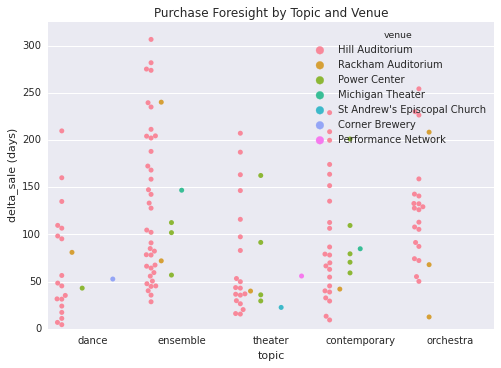

In [17]:
df_tmp = df.drop_duplicates(subset='perf_name')
clust_dict = dict(zip(df_tmp['perf_name'].tolist(), df_tmp['venue'].tolist()))
df_perf['venue'] = df['perf_name'].map(clust_dict.get)
sp = sns.swarmplot(x='topic', y='delta_sale', data=df_perf, hue='venue', split=True)

plt.title('Purchase Foresight by Topic and Venue')
plt.xticks(range(5), t_list)
sp.set_ylim([0, 325])
sp.set_ylabel("delta_sale (days)")
plt.savefig('Projects/images/foresight.png', dpi=100)
plt.show()